CPU times: user 17.5 ms, sys: 275 µs, total: 17.8 ms
Wall time: 17.8 ms
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 8.84849139397902
       x: [ 3.014e-12  1.100e-01 ...  0.000e+00  0.000e+00]
     nit: 10
     jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
    nfev: 340
    njev: 10


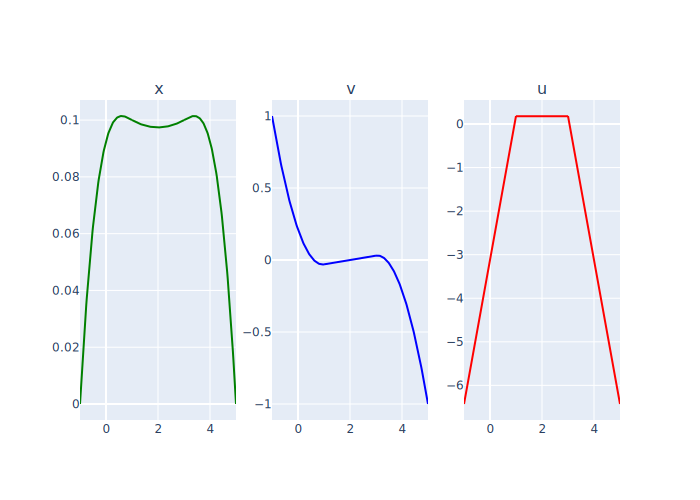

In [10]:
from itertools import accumulate
from scipy.optimize import minimize
from scipy.special import roots_legendre
import numpy as np
import math


def chebyshev_points(n):
    return -np.cos(np.linspace(0.5*np.pi/n, (n-0.5)*np.pi/n, n))

def chebyshev_points_2(n):
    return -np.cos(np.linspace(0, np.pi, n));

def lagrange_basis(x):
    N = len(x)
    b = [1]*N
    for i in range(N):
        p = np.polynomial.Polynomial([-x[i], 1], symbol='t')
        for j in range(N):
            if i != j:
                b[j] *= p/(x[j]-x[i])
    return b

def bernstein_basis(n):
    return [math.comb(n-1, i) * np.polynomial.Polynomial([0.5, 0.5], symbol='t')**i * np.polynomial.Polynomial([0.5, -0.5], symbol='t')**(n-i-1) for i in range(n)]


class Element:
    def __init__(self, state_len, state_degree, control_len, control_degree, state_offset, dt, basis=bernstein_basis):
        self.f = basis(state_degree)
        self.h = basis(control_degree)
        self.g = basis(state_degree+1)
        self.dt = dt
        self.x_slice = slice(state_offset, state_offset+state_len*state_degree)
        self.u_slice = slice(state_offset+state_len*state_degree, state_offset+state_len*state_degree+control_len*control_degree)

    def X(self, t):
        fM = np.array([b(t) for b in self.f])
        return lambda x, out=None: np.dot(x[self.x_slice].reshape(-1, len(self.f)), fM, out=out)

    def U(self, t):
        hM = np.array([b(t) for b in self.h])
        return lambda x, out=None: np.dot(x[self.u_slice].reshape(-1, len(self.h)), hM, out=out)


class System:
    def __init__(self, state_len, control_len, F):
        self.state_len = state_len
        self.control_len = control_len
        self.F = F
        self.dynamics_degree = 6


def build_elements(mesh, state_len, control_len):
    offsets = list(accumulate((state_len*state_degree + control_len*control_degree for state_degree, control_degree, _ in mesh), initial=0))
    return [Element(state_len, state_degree, control_len, control_degree, offset, dt) for (state_degree, control_degree, dt), offset in zip(mesh, offsets)]


def eval_function(F, el, ts):
    X, U = el.X(ts), el.U(ts)
    return lambda x: F(X(x),U(x))

def integrate_function(F, el, n):
    ts, ws = roots_legendre(n)
    Ft = eval_function(F, el, ts)
    return lambda x: np.dot(Ft(x), ws)

def make_diff_constraints(F, el, tt):
    dynamics_degree = len(el.g)  # TODO: pass dynamics degree?
    n = (len(el.g)+dynamics_degree)//2 + 1
    ts, ws = roots_legendre(n)
    gM = np.array([b(ts) for b in el.g]).reshape(len(el.g), 1, n)
    gdM = np.array([b.deriv()(ts) for b in el.g]).reshape(len(el.g), 1, n)
    X,U,dt = el.X(ts), el.U(ts), el.dt
    def compute(y):
        x,u = X(y),U(y)
        return np.dot(0.5*dt*tt(y)*gM*F(x,u) + gdM*x, ws)
    return compute

def interpolate_guess(boundary, mesh):
    (X0,U0), (Xf,Uf) = boundary

    guess = np.empty(0)
    
    ts = np.cumsum([0]+[dt for (_,_,dt) in mesh]).reshape(-1,1)
    dx = [X0]*(1-ts) + [Xf]*ts
    du = [U0]*(1-ts) + [Uf]*ts
    return dx, du

def interpolate_state(guess, mesh):
    dx, du = guess
    state = np.empty(0)
    for x0, xf, u0, uf, (nx, nu, dt) in zip(dx, dx[1:], du, du[1:], mesh):
        state = np.append(state, np.linspace(x0, xf, nx).swapaxes(0,1).reshape(-1))
        state = np.append(state, np.linspace(u0, uf, nu).swapaxes(0,1).reshape(-1))
    return state

def solve(L, G, system, boundary, elements, guess):
    (X0,t0), (Xf,tf) = boundary
    if tf is None:
        tt = lambda x: x[-1]-t0
    else:
        tt = lambda x: tf-t0

    def diff_constraints(x, compute=[make_diff_constraints(system.F, el, tt) for el in elements]):
        Cs = [dc(x) for dc in compute]
        r = []
        for c, x0 in zip(Cs[0][0], X0):
            if x0 is not None:
                r.append(c+x0)
        for c, xf in zip(Cs[-1][-1], Xf):
            if xf is not None:
                r.append(c-xf)
        for cs in Cs:
            r += cs[1:-1].reshape(-1).tolist()
        for csA,csB in zip(Cs, Cs[1:]):
            r += (csA[-1]+csB[0]).tolist()      
        return np.array(r)
    
    def trans_constraints(x, compute=[eval_function(G, el, np.linspace(-1, 1, len(el.f))) for el in elements]):
        return np.hstack([G(x) for G in compute]).reshape(-1)

    cs = [{'type': 'eq', 'fun': diff_constraints}, {'type': 'ineq', 'fun': trans_constraints}] 

    cost_bits = [(integrate_function(L, el, len(el.f)+1) if callable(L) else lambda x: 2.0*L, el.dt) for el in elements]    
    def cost(x):
        t = tt(x)
        return sum(0.5*dt*t*cost_bit(x) for cost_bit, dt in cost_bits)
    
    return minimize(cost, method='SLSQP', x0=guess, constraints=cs, jac='2-point', options={'maxiter':2000})

F = lambda X,U: np.array([X[1], U[0]])
L = lambda X,U: U[0]**2
G = lambda X,U: np.array([0.1-X[0]])
e = build_elements([(4,3,0.33), (3, 2,0.34), (4,3,0.33)], 2, 1)
%time r = solve(L, G, System(2, 1, F), (((0,1),0), ((0,-1),1)), e, np.zeros(33))  # , basis=lambda n: lagrange_basis(chebyshev_points(n)))
print(r)

import plotly.graph_objects as graphs
from plotly.subplots import make_subplots
fig = make_subplots(cols=3, rows=1, column_titles=['x', 'v', 'u'], figure=graphs.FigureWidget())
t = np.linspace(-1,1,101)
for i,element in enumerate(e):
    fig.add_scatter(x=t+2*i, y=element.X(t)(r.x)[0], name='x', line={'color': 'green'}, showlegend=False, col=1, row=1)
    fig.add_scatter(x=t+2*i, y=element.X(t)(r.x)[1], name='v', line={'color': 'blue'}, showlegend=False, col=2, row=1)
    fig.add_scatter(x=t+2*i, y=element.U(t)(r.x)[0], name='u', line={'color': 'red'}, showlegend=False, col=3, row=1)
fig.show()

CPU times: user 500 ms, sys: 368 µs, total: 501 ms
Wall time: 501 ms
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 109.23086625385336
       x: [ 2.570e-07  1.216e-06 ... -1.570e+00  1.092e+02]
     nit: 43
     jac: [ 0.000e+00  0.000e+00 ... -0.000e+00  1.000e+00]
    nfev: 5462
    njev: 43


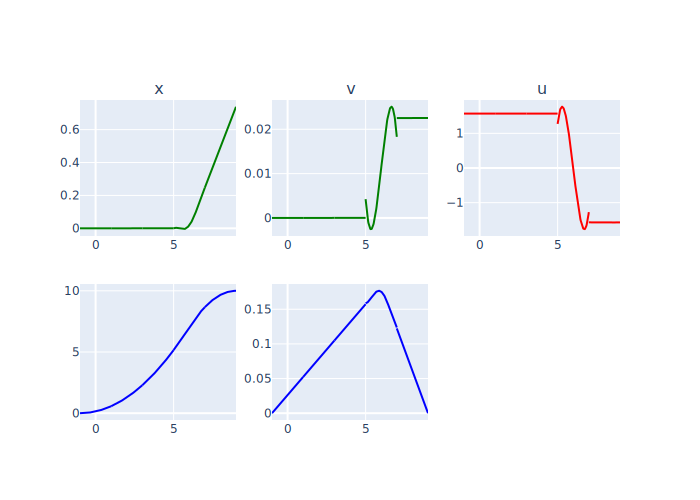

In [11]:
h = 10
g = 1.6e-3
a = 4e-3
half_pi = 0.5*np.pi
F = lambda X,U: np.array([
    X[2], X[3], a*np.cos(U[0]), a*np.sin(U[0]) - g
])
G = lambda X,U: np.array([half_pi-U[0], half_pi+U[0]])
L = 1
mesh = [(5,5,0.2)]*5
guess = interpolate_guess((((0,0,0,0), (0,)), ((0,h,0,0), (0,))), mesh)
state = interpolate_state(guess, mesh)
state = np.append(state, 100)
e = build_elements(mesh, 4, 1)
%time r = solve(L, G, System(4, 1, F), (((0,0,0,0), 0), ((None,h,None,0), None)), e, state)  #, basis=lambda n: lagrange_basis(chebyshev_points_2(n)))
print(r)

fig = make_subplots(cols=3, rows=2, column_titles=['x', 'v', 'u'], figure=graphs.FigureWidget())
t = np.linspace(-1,1,101)
for i,element in enumerate(e):
    X = element.X(t)
    U = element.U(t)
    fig.add_scatter(x=t+2*i, y=X(r.x)[0], name='x', line={'color': 'green'}, showlegend=False, col=1, row=1)
    fig.add_scatter(x=t+2*i, y=X(r.x)[1], name='y', line={'color': 'blue'}, showlegend=False, col=1, row=2)
    fig.add_scatter(x=t+2*i, y=X(r.x)[2], name='vx', line={'color': 'green'}, showlegend=False, col=2, row=1)
    fig.add_scatter(x=t+2*i, y=X(r.x)[3], name='vy', line={'color': 'blue'}, showlegend=False, col=2, row=2)
    fig.add_scatter(x=t+2*i, y=U(r.x)[0], name='u', line={'color': 'red'}, showlegend=False, col=3, row=1)
fig.show()

In [12]:
mu = 65138397520.7807  #m^3/s^2
Tmax = 2 # kN
A = 0.00064743886468932  # tonne/s

R = 200000
r_init = R + 3979.64627231815  # m
r_min = R + 7000
theta_min = 1000*np.pi/R
vr_init = 0
vt_init = 9.22148055307808  # m/s
m_init = 0.27674999833107  # tonne

r_final = R + 30000  # m
vt_final = math.sqrt(mu/r_final)
#print(vt_final*m_init/Tmax)

F = lambda X,U: np.array([
    X[2],
    X[3]/X[0],
    X[3]**2/X[0] - mu/X[0]**2 + U[1]*np.cos(U[0])/X[4],
    -X[2]*X[3]/X[0] + U[1]*np.sin(U[0])/X[4],
    -A*U[1]/Tmax
])
G = lambda X,U: np.array([
    np.pi - U[0],
    np.pi + U[0],
    Tmax - U[1],
    U[1],
    X[1],
    2*np.pi - X[1],
    X[0] - np.where(X[1] >= theta_min, r_min, r_init+(r_min-r_init)*X[1]*(2*theta_min-X[1])/theta_min**2)
])
L = lambda X,U: U[1]
mesh = [(2,2,.2)]*5
guess = interpolate_guess((((r_init,0,vr_init,vt_init,m_init), (0,2)), ((r_final,np.pi,0,vt_final,m_init), (0.5*np.pi,0))), mesh)
state = interpolate_state(guess, mesh)
state = np.append(state, 1200)
e = build_elements(mesh, 5, 2)

%time r = solve(L, G, System(5, 2, F), (((r_init,0,vr_init,vt_init,m_init), 0), ((r_final,None,0,vt_final,None), None)), e, state)  #, basis=lambda n: lagrange_basis(chebyshev_points_2(n)))
print(r)
print(r.x[-1])

CPU times: user 3.02 s, sys: 2.06 ms, total: 3.02 s
Wall time: 3.03 s
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 191.3105553898164
       x: [ 2.040e+05  2.070e+05 ...  2.209e-01  5.944e+02]
     nit: 308
     jac: [ 0.000e+00  0.000e+00 ...  5.944e+01  3.219e-01]
    nfev: 22212
    njev: 308
594.3594745821991


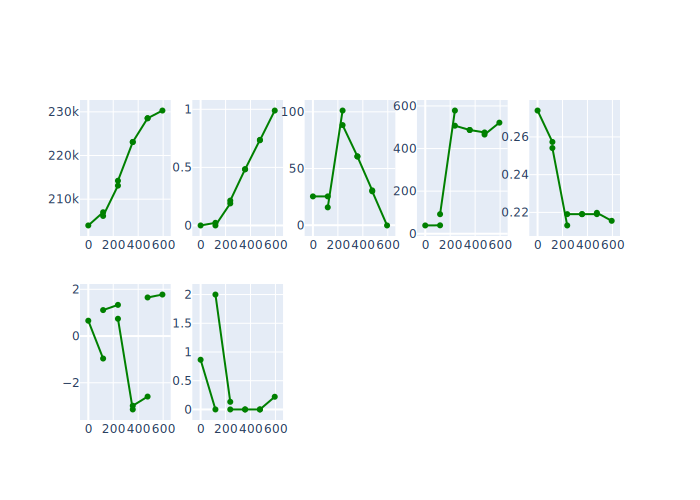

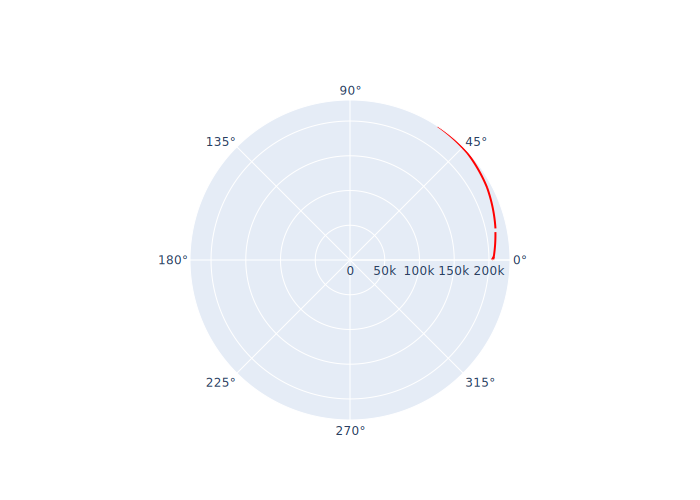

In [13]:
fig = make_subplots(cols=5, rows=2, figure=graphs.FigureWidget())
t = np.linspace(-1,1,101)
et = 0
for i,element in enumerate(e):
    t = np.linspace(-1,1,len(element.f))
    X = element.X(t)(r.x)
    for j in range(5):
        fig.add_scatter(x=et+0.5*(t+1)*r.x[-1]*element.dt, y=X[j], name=f'x{i}', line={'color': 'green'}, showlegend=False, col=j+1, row=1)
    U = element.U(t)(r.x)
    for j in range(2):
        fig.add_scatter(x=et+0.5*(t+1)*r.x[-1]*element.dt, y=U[j], name=f'u{i}', line={'color': 'green'}, showlegend=False, col=j+1, row=2)
    et += r.x[-1]*element.dt
        
fig.show()
fig = make_subplots(cols=1, rows=1, figure=graphs.FigureWidget())
t = np.linspace(-1,1,101)
for i,element in enumerate(e):
    X = element.X(t)(r.x)
    fig.add_scatterpolar(r=X[0], theta=X[1]*(180/np.pi), line={'color': 'red'}, showlegend=False)
fig.show()

In [ ]:
rErr = [np.linalg.norm(elA.X(1)(r.x) - elB.X(-1)(r.x))/max(np.linalg.norm(elA.X(1)(r.x)), np.linalg.norm(elA.X(1)(r.x))) for elA, elB in zip(e, e[1:])]
print(rErr)

def refine_mesh(mesh, boundary_guess, boundary_errors, tol=1e-5):
    new_mesh = []
    new_guess = boundary_guess
    err_extended = [0] + rErr2 + [0]
    element_error = [max(eA, eB) for eA,eB in zip(rErr3, rErr3[1:])]
    
    for (nx,nu,dt), err in zip(mesh, element_error):
        if err <= tol:
            new_mesh += (nx,nu,dt)
            continue
        c = err/(el.dt**(len(el.f)+1))
        n = np.arange(1,6)
        p = np.maximum(2, np.ceil(np.log(tol/c)/np.log(el.dt/n))-1)
        exp = c * (el.dt/n)**(p+1)
        idx = np.argmin(n*p)
        if n[idx] > 1:
            raise "bad"
        new_mesh.append((p[idx], p[idx], dt))
    return new_mesh, new_guess

xguess = [e[0].X(-1)(r.x)] + [0.5*elA.X(1)(r.x) + 0.5*elB.X(-1)(r.x) for elA,elB in zip(e, e[1:])] + [e[-1].X(1)(r.x)]
uguess = [e[0].U(-1)(r.x)] + [0.5*elA.U(1)(r.x) + 0.5*elB.U(-1)(r.x) for elA,elB in zip(e, e[1:])] + [e[-1].U(1)(r.x)]
mesh2, guess2 = refine_mesh(mesh, (xguess,uguess), rErr)
state2 = interpolate_state(guess2, mesh2)
state2 = np.append(state2, r.x[-1])
e2 = build_elements(mesh, 5, 2)
%time r = solve(L, G, System(5, 2, F), (((r_init,0,vr_init,vt_init,m_init), 0), ((r_final,None,0,vt_final,None), None)), e2, state2)  #, basis=lambda n: lagrange_basis(chebyshev_points_2(n)))
print(r)
print(r.x[-1])

In [ ]:
import os

def print_list(a):
    return f'list({", ".join(str(x) for x in a)})'

def print_el(el, fr, to):
    us = r.x[el.u_slice].reshape(-1, len(el.h))
    a = sum(b*w for b,w in zip(el.h, us[0]))*180/math.pi
    t = sum(b*w for b,w in zip(el.h, us[1]))/Tmax
    z = (2*20 - fr - to)/(to-fr)
    return f'lexicon("from", {fr}, "to", {to}, "a", {print_list(a.coef[::-1])}, "t", {print_list(t.coef[::-1])})'

def print_traj(elements, tf, t0=0):
    t_end = np.cumsum([el.dt for el in elements])*(tf-t0) + t0
    t_start = np.insert(t_end, 0, t0)
    return f'list({(", ").join(print_el(el, t_start[i], t_end[i]) for i,el in enumerate(elements))})'

print(print_traj(e, r.x[-1]))

In [ ]:
from scipy.integrate import solve_ivp

def simulate(F, t_span, y0, elements, x):
    t_end = np.cumsum([el.dt for el in elements])*(t_span[1]-t_span[0]) + t_span[0]
    t_start = np.insert(t_end, 0, t_span[0])
    def fun(t, y):
        idx = np.searchsorted(t_end, t)
        el = elements[min(idx,len(elements)-1)]
        tau = 2*((t-t_start[idx])/(t_span[1]-t_span[0])/el.dt)-1.0
        return F(y, el.U(tau)(x))

    return solve_ivp(fun, t_span, y0, dense_output=True)

def blah(t_span, elements, x):
    dt = (t_span[1]-t_span[0])/len(elements)
    def fun(t):
        idx = max(0, min(int((t-t_span[0])/dt), len(elements)-1))
        el = elements[idx]
        tau = 2*(t/dt-idx)-1.0
        return np.array([xi(x) for xi in el.X(tau)])
    return fun

tf = r.x[-1]
s = simulate(F, (0,tf), (r_init,0,vr_init,vt_init,m_init), e, r.x)
print(s)
t = np.linspace(0,tf,1001)
sol = s.sol(t)

fig = make_subplots(cols=5, rows=1, figure=graphs.FigureWidget())
for i in range(5):
    fig.add_scatter(x=t, y=sol[i], name='x', line={'color': 'green'}, showlegend=False, col=i+1, row=1)

fig.show()

#X = blah((0,1), e, r.x)
#np.linalg.norm(np.array([X(ti) for ti in t]) - sol.T, axis=1)
#fig.add_scatter(x=t, y=np.linalg.norm(np.array([X(ti) for ti in t]) - sol.T, axis=1), name='e', line={'color': 'red'}, showlegend=False, col=3, row=1)

In [ ]:
ids = []
parents = []
values = []
labels = []
recursion = set()

def go_deep(func, stats, cutoff=0.05, frac=1.0):
    fid = ids[-1]
    for calee in stats.all_callees[func].keys():
        if stats.stats[calee][3] < cutoff:
            continue
        ids.append(len(ids))
        parents.append(fid)
        values.append(stats.stats[calee][4][func][3]*frac)
        labels.append(f'{calee[0]}:{calee[1]} {calee[2]}')
        if calee not in recursion:
            recursion.add(calee)
            go_deep(calee, stats, cutoff=cutoff, frac=frac*stats.stats[calee][4][func][3]/stats.stats[calee][3])
            recursion.remove(calee)

def get_roots(stats):
    return [func for func, (cc, nc, tt, ct, callers) in stats.stats.items() if not callers]

stats.calc_callees()
for func in get_roots(stats)[:1]:
    ids.append(len(ids))
    parents.append(None)
    values.append(stats.stats[func][3])
    labels.append(func[2])
    recursion.add(func)
    go_deep(func, stats, cutoff=5)

print(len(ids))
graphs.FigureWidget(data=[graphs.Icicle(ids=ids, parents=parents, labels=labels, values=values, branchvalues='total')
]).show()

## TODO
* [x] Non-uniform length elements (dt)
* [x] Better guess input
* * [x] for time
* * [x] for control
* * [x] output can be fed as input
* * [ ] specify guess at element boundaries
* [ ] Mesh refinement
* * [ ] Error estimation
* [ ] Terminal state value cost function
* [ ] Multi-stage
* * [ ] Mid-path constraints


In [ ]:
d = 1000

x = np.linspace(0, 2000, 1001)
y = r_min*x*(2*d-x)/d**2

graphs.FigureWidget(data=[graphs.Scatter(x=x,y=y+200000)
]).show()

In [ ]:
theta_min

In [ ]:
t = [np.array([[0.1, 0.1, 0.1, 0.1]]), np.array([[0.1, 0.1, 0.1]]), np.array([[0.1, 0.1, 0.1, 0.1]])]

In [ ]:
np.hstack(t)